## 1. Import libraries

In [14]:
# ===== Data & visualization libs =====
import matplotlib.pyplot as plt  # basic plotting
import seaborn as sns            # prettier plots
import pandas as pd              # tabular data
import numpy as np
import string
import re

# sklearn models/features
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import joblib


# 2. Data Understanding & EDA

##  2.1 Read Data

In [15]:
# Read Data CSV
Filename = "spam.csv"
df = pd.read_csv(Filename)

df = df.drop_duplicates()

print(f"The size of the dataset is: {df.shape} \n")

# View the first five rows.
print("View the first five rows:")
display(df.head())

print("\n Check the data distribution")
print(df["Category"].value_counts())

The size of the dataset is: (5157, 2) 

View the first five rows:


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"



 Check the data distribution
Category
ham     4516
spam     641
Name: count, dtype: int64


### 2.2 Exploratory Data Analysis (EDA)
We examine data quality, class balance, message length, text signals, and common tokens. We also compare the training and validation sets to check for distribution shifts.


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
from pathlib import Path
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from IPython.display import display

sns.set_theme(style="whitegrid")
pd.set_option("display.max_colwidth", 120)

DATA_DIR = Path(".")
train_path = DATA_DIR / "spam.csv"
val_path = DATA_DIR / "Validate.csv"

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

df_train.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


#### 2.2.1 Data Quality and Schema
We check shapes, missing values, duplicates, and raw label values.


In [17]:
def basic_report(df, name):
    print(f"{name} shape: {df.shape}")
    display(df.head(3))
    print("Missing values:")
    display(df.isna().sum().sort_values(ascending=False))
    print("Duplicate rows:", df.duplicated().sum())
    print("Duplicate messages:", df.duplicated(subset=["Message"]).sum())
    print("Raw Category values:")
    display(df["Category"].value_counts(dropna=False))

basic_report(df_train, "Train")
basic_report(df_val, "Validation")


Train shape: (5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std t...


Missing values:


Category    0
Message     0
dtype: int64

Duplicate rows: 415
Duplicate messages: 415
Raw Category values:


Category
ham     4825
spam     747
Name: count, dtype: int64

Validation shape: (5728, 2)


,Category,Message
0,spam,naturally irresistible your corporate identity lt is really hard to recollect a company : the market is full of su...
1,spam,the stock trading gunslinger fanny is merrill but muzo not colza attainder and penultimate like esmark perspicuous ...
2,spam,"unbelievable new homes made easy im wanting to show you this homeowner you have been pre - approved for a $ 454 ,..."


Missing values:


Category    0
Message     0
dtype: int64

Duplicate rows: 33
Duplicate messages: 33
Raw Category values:


Category
ham     4360
spam    1368
Name: count, dtype: int64

#### 2.2.2 Normalize Labels and Engineer Text Features
We normalize labels and compute basic text features for further analysis.


In [34]:
def normalize_category(series):
    s = series.astype(str).str.strip().str.lower()
    return s.replace({"0": "ham", "1": "spam"})

def add_text_features(df):
    df = df.copy()
    text = df["Message"].fillna("").astype(str)
    df["Message_clean"] = text
    df["char_len"] = text.str.len()
    df["word_len"] = text.str.split().str.len()
    df["avg_word_len"] = text.apply(lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0)
    df["num_upper"] = text.apply(lambda x: sum(1 for c in x if c.isupper()))
    df["upper_ratio"] = (df["num_upper"] / df["char_len"].replace(0, np.nan)).fillna(0)
    df["num_digits"] = text.str.count(r"\d")
    df["num_punct"] = text.str.count(rf"[{re.escape(string.punctuation)}]")
    df["num_excl"] = text.str.count(r"!")
    df["num_qmark"] = text.str.count(r"\?")
    df["num_urls"] = text.str.count(r"(https?://|www\.)")
    df["num_emails"] = text.str.count(r"[\w\.-]+@[\w\.-]+\.\w+")
    return df

df_train_eda = add_text_features(df_train.assign(Category_norm=normalize_category(df_train["Category"]), source="train"))
df_val_eda = add_text_features(df_val.assign(Category_norm=normalize_category(df_val["Category"]), source="validate"))
df_all = pd.concat([df_train_eda, df_val_eda], ignore_index=True)


#### 2.2.3 Class Distribution
We inspect class balance for both train and validation.


,source,Category_norm,count,ratio
0,train,ham,4825,0.865937
1,train,spam,747,0.134063
2,validate,ham,4360,0.761173
3,validate,spam,1368,0.238827


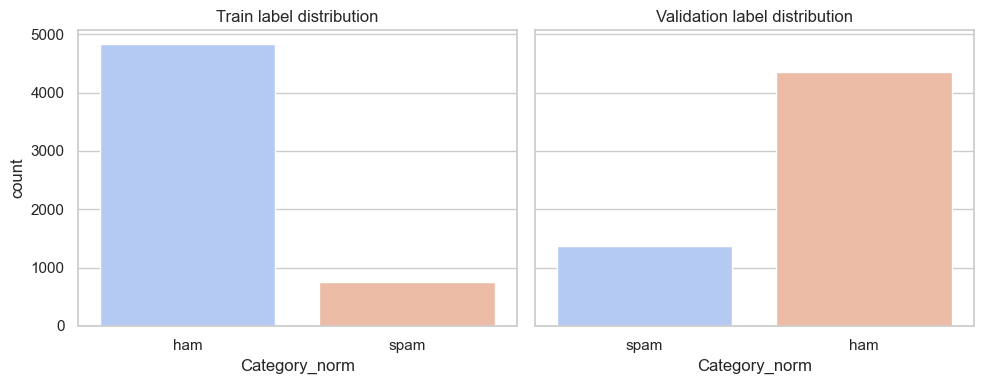

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.countplot(data=df_train_eda, x="Category_norm", hue="Category_norm", ax=axes[0], palette="coolwarm")
legend = axes[0].get_legend()
if legend:
    legend.remove()
axes[0].set_title("Train label distribution")
sns.countplot(data=df_val_eda, x="Category_norm", hue="Category_norm", ax=axes[1], palette="coolwarm")
legend = axes[1].get_legend()
if legend:
    legend.remove()
axes[1].set_title("Validation label distribution")
plt.tight_layout()

label_ratio = (
    df_all.groupby(["source", "Category_norm"])
    .size()
    .reset_index(name="count")
)
label_ratio["ratio"] = label_ratio.groupby("source")["count"].transform(lambda x: x / x.sum())
label_ratio


#### 2.2.4 Message Length and Structure
We analyze length-based patterns that often differentiate spam vs ham.


Category_norm               ham        spam
char_len     count  4825.000000  747.000000
             mean     71.448290  137.989290
             std      58.434864   29.980287
             min       2.000000    7.000000
             25%      33.000000  132.000000
             50%      52.000000  149.000000
             75%      93.000000  157.000000
             max     910.000000  223.000000
word_len     count  4825.000000  747.000000
             mean     14.310259   23.812584
             std      11.517945    5.956923
             min       1.000000    1.000000
             25%       7.000000   22.000000
             50%      11.000000   25.000000
             75%      19.000000   28.000000
             max     171.000000   35.000000
avg_word_len count  4825.000000  747.000000
             mean      4.167562    4.974508
             std       1.126884    1.005700
             min       1.500000    3.333333
             25%       3.600000    4.400000
             50%       4.000000    4.851852
             75%       4.500000    5.371711
             max      49.000000   17.333333

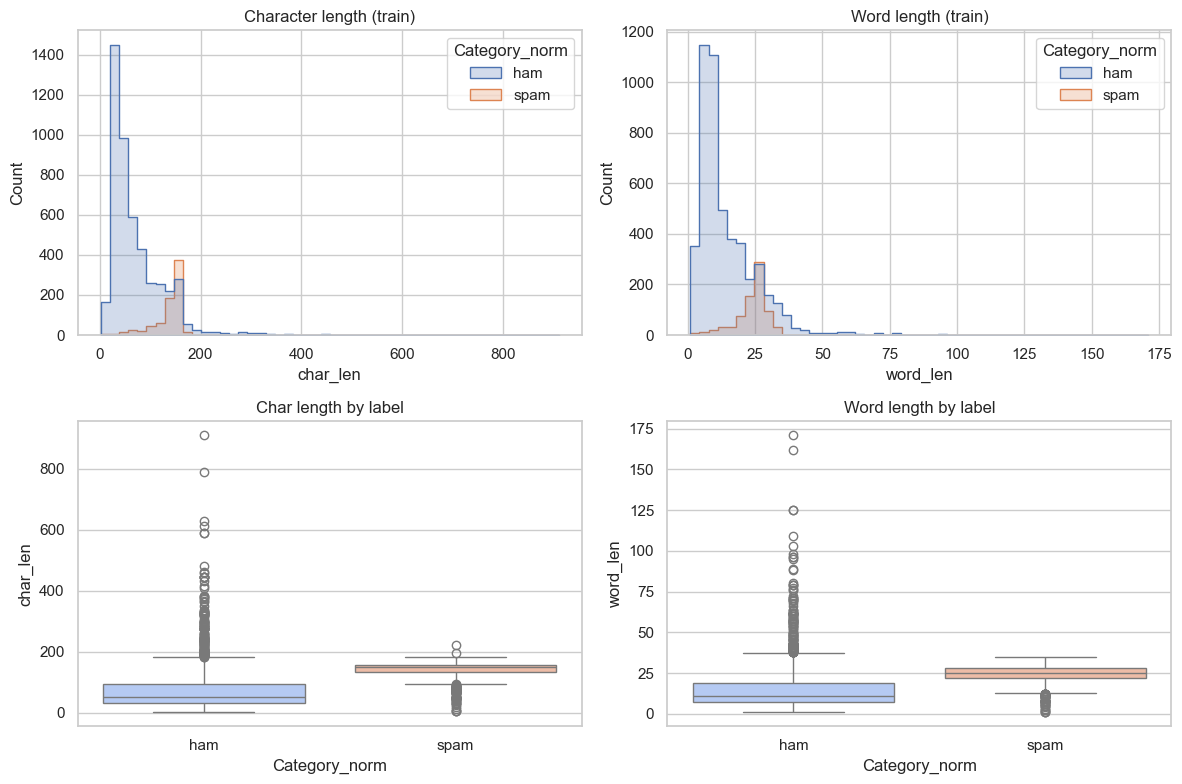

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(data=df_train_eda, x="char_len", hue="Category_norm", bins=50, ax=axes[0, 0], element="step")
axes[0, 0].set_title("Character length (train)")
sns.histplot(data=df_train_eda, x="word_len", hue="Category_norm", bins=50, ax=axes[0, 1], element="step")
axes[0, 1].set_title("Word length (train)")
sns.boxplot(data=df_train_eda, x="Category_norm", y="char_len", hue="Category_norm", ax=axes[1, 0], palette="coolwarm")
legend = axes[1, 0].get_legend()
if legend:
    legend.remove()
axes[1, 0].set_title("Char length by label")
sns.boxplot(data=df_train_eda, x="Category_norm", y="word_len", hue="Category_norm", ax=axes[1, 1], palette="coolwarm")
legend = axes[1, 1].get_legend()
if legend:
    legend.remove()
axes[1, 1].set_title("Word length by label")
plt.tight_layout()

df_train_eda.groupby("Category_norm")[["char_len", "word_len", "avg_word_len"]].describe().T


#### 2.2.5 Example Messages
We sample a few spam and ham messages to understand typical patterns.


In [21]:
spam_samples = df_train_eda[df_train_eda["Category_norm"] == "spam"]["Message_clean"].sample(3, random_state=42)
ham_samples = df_train_eda[df_train_eda["Category_norm"] == "ham"]["Message_clean"].sample(3, random_state=42)

print("Spam samples:")
for s in spam_samples:
    print("-", s)

print("Ham samples:")
for s in ham_samples:
    print("-", s)


Spam samples:
- Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804
- This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate
- Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just £1.50 per wk 2 opt out send STOP 08452810071 16
Ham samples:
- If i not meeting ü all rite then i'll go home lor. If ü dun feel like comin it's ok.
- I.ll always be there, even if its just in spirit. I.ll get a bb soon. Just trying to be sure i need it.
- Sorry that took so long, omw now


#### 2.2.6 Common Words and N-grams
We extract top tokens and bigrams for each label (basic lexical signal exploration).

(                ngram  count
 0            http www    318
 1            jul 2005    159
 2              19 jul    154
 3        mailing list    112
 4     forward looking    112
 5      search engines    111
 6       email address    110
 7      submit website    103
 8             2005 10    102
 9  looking statements    101,
               ngram  count
 0           hou ect   5227
 1           ect ect   4881
 2    vince kaminski   4103
 3         enron com   2244
 4        cc subject   2060
 5      kaminski hou   1778
 6            ect cc   1583
 7       enron enron   1554
 8          let know   1554
 9  shirley crenshaw   1045)

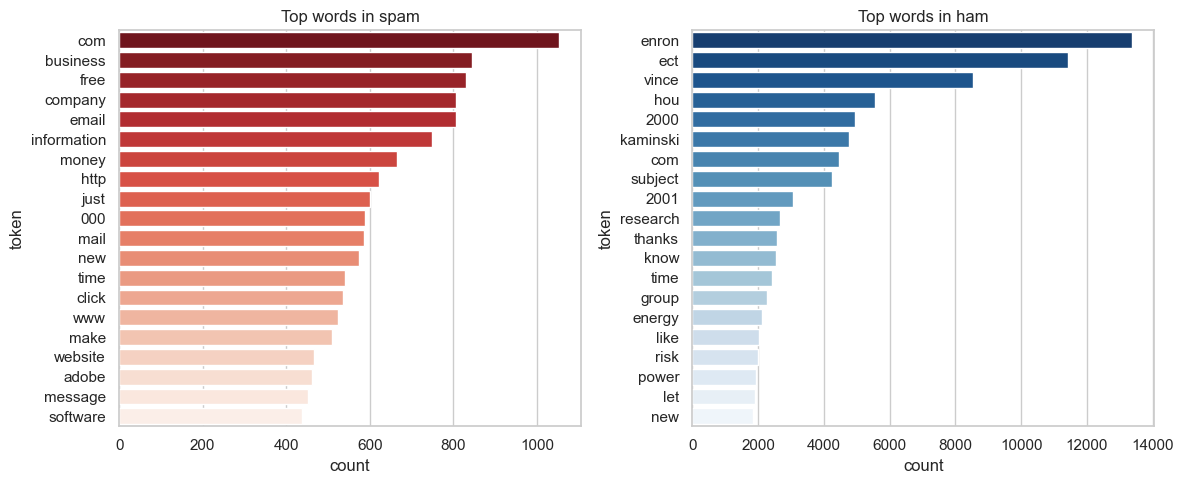

In [37]:
stop_words = set(ENGLISH_STOP_WORDS)

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 2]
    return tokens

def top_tokens(df, label, n=20):
    counter = Counter()
    texts = df.loc[df["Category_norm"] == label, "Message_clean"]
    for t in texts:
        counter.update(tokenize(t))
    return pd.DataFrame(counter.most_common(n), columns=["token", "count"])

top_spam = top_tokens(df_all, "spam", 20)
top_ham = top_tokens(df_all, "ham", 20)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=top_spam, x="count", y="token", hue="token", ax=axes[0], palette="Reds_r")
legend = axes[0].get_legend()
if legend:
    legend.remove()
axes[0].set_title("Top words in spam")
sns.barplot(data=top_ham, x="count", y="token", hue="token", ax=axes[1], palette="Blues_r")
legend = axes[1].get_legend()
if legend:
    legend.remove()
axes[1].set_title("Top words in ham")
plt.tight_layout()

def top_ngrams(texts, ngram_range=(2, 2), top_n=20):
    vec = CountVectorizer(stop_words="english", ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(texts)
    sums = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = sums.argsort()[::-1][:top_n]
    return pd.DataFrame({"ngram": vocab[top_idx], "count": sums[top_idx]})

spam_bigrams = top_ngrams(df_all[df_all["Category_norm"] == "spam"]["Message_clean"], (2, 2), 15)
ham_bigrams = top_ngrams(df_all[df_all["Category_norm"] == "ham"]["Message_clean"], (2, 2), 15)

spam_bigrams.head(10), ham_bigrams.head(10)


#### 2.2.7 Spam Signal Features
We inspect features commonly associated with spam (URLs, punctuation, uppercase usage).


,num_urls,num_emails,num_excl,num_qmark,num_digits,upper_ratio
Category_norm,,,,,,
ham,0.000,0.000,0.177,0.285,0.305,0.058
spam,0.154,0.008,0.731,0.234,15.640,0.113


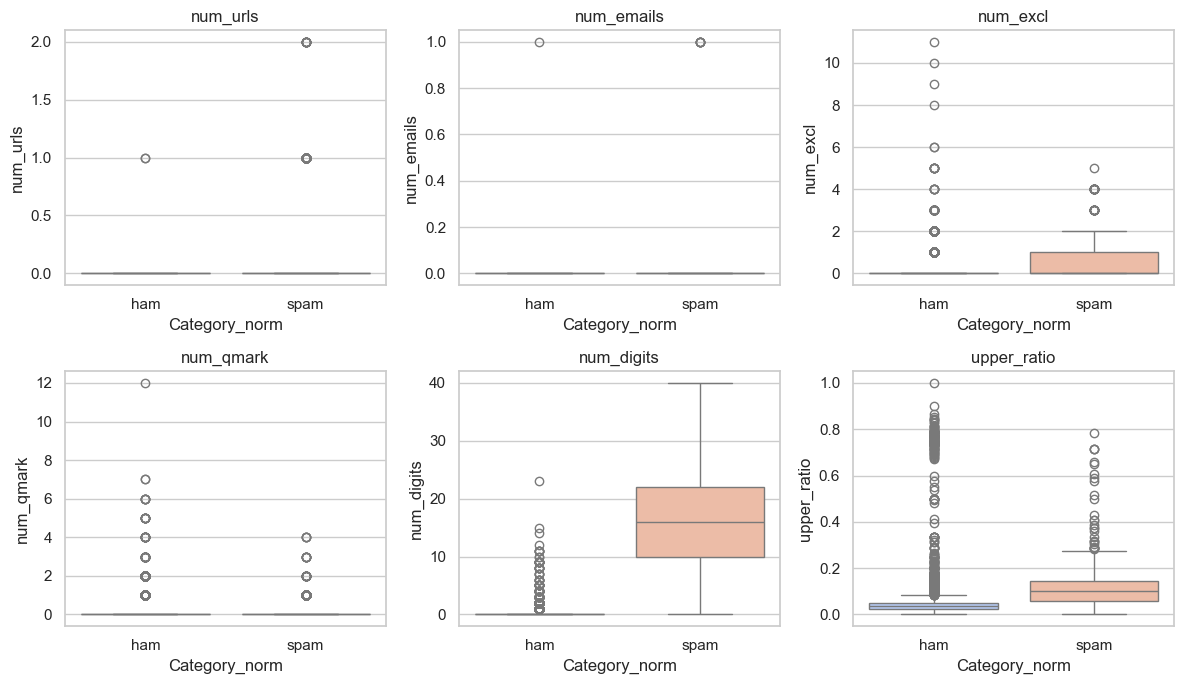

In [23]:
signal_cols = ["num_urls", "num_emails", "num_excl", "num_qmark", "num_digits", "upper_ratio"]
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()
for i, col in enumerate(signal_cols):
    sns.boxplot(data=df_train_eda, x="Category_norm", y=col, hue="Category_norm", ax=axes[i], palette="coolwarm")
    legend = axes[i].get_legend()
    if legend:
        legend.remove()
    axes[i].set_title(col)
plt.tight_layout()

df_train_eda.groupby("Category_norm")[signal_cols].mean().round(3)


#### 2.2.8 Train vs Validation Comparison and Overlap
We compare basic statistics and look for message overlap or label conflicts.


In [24]:
length_summary = (
    df_all.groupby(["source", "Category_norm"])[["char_len", "word_len"]]
    .agg(["mean", "median"])
)
length_summary

train_dupes = df_train_eda.duplicated(subset=["Message_clean"]).sum()
val_dupes = df_val_eda.duplicated(subset=["Message_clean"]).sum()
overlap = set(df_train_eda["Message_clean"]).intersection(set(df_val_eda["Message_clean"]))

print("Duplicate messages in train:", train_dupes)
print("Duplicate messages in validation:", val_dupes)
print("Overlap messages between train and validation:", len(overlap))

label_conflicts = df_all.groupby("Message_clean")["Category_norm"].nunique()
conflicts = label_conflicts[label_conflicts > 1]
print("Messages with conflicting labels:", len(conflicts))


Duplicate messages in train: 415
Duplicate messages in validation: 33
Overlap messages between train and validation: 0
Messages with conflicting labels: 0


## 3. Data pre-processing

###  3.1 Data cleaning and normalization

In [26]:
# Text data preprocessing

def clean_text(text):
    text = text.lower()                                 # "Free Money" → "free money"
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation: "Hello!!! Free?? Money." → "Hello Free Money"
    text = re.sub(r"\d+", "", text)                     # Remove numbers: "Win 1000 dollars now" → "Win dollars now"
    return text

df['Message'] = df['Message'].apply(clean_text)

### 3.2 Encode labels

In [27]:
df = df[df["Category"].isin(['ham', 'spam'])] # Select only spam and ham samples

X = df["Message"]
y = df['Category']

print("Select only spam and ham samples:")
print(y.value_counts())

print("\nCheck label distribution (by proportion):")
print(y.value_counts()/len(y))

y = y.map({
    'ham': 0,
    'spam': 1
  })  # Convert labels to numbers

Select only spam and ham samples:
Category
ham     4516
spam     641
Name: count, dtype: int64

Check label distribution (by proportion):
Category
ham     0.875703
spam    0.124297
Name: count, dtype: float64


## 4. Data Processing


### 4.1 Split into training/testing sets

In [28]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
  )

print("The data has been split into training/testing sets with an 80/20 ratio")

The data has been split into training/testing sets with an 80/20 ratio


### 4.2 TF-IDF Vectorizer

In [29]:
# Convert text into numerical vectors
vectorizer = TfidfVectorizer()

# Step 1: Fit the vectorizer on the training data
vectorizer.fit(X_train)

# Assume the vectorizer is a trained TfidfVectorizer object
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Bước 2: Transform the training data into numerical vectors
X_train_tfidf = vectorizer.transform(X_train)

X_test_tfidf = vectorizer.transform(X_test)

## 5. Train models (5 options)

In [30]:
# Train 5 models
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Linear SVM": LinearSVC(),
    "Multinomial NB": MultinomialNB(),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=42)
}

results = []
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "name": name,
        "model": clf,
        "y_pred": y_pred,
        "accuracy": acc,
        "report": report_dict,
        "cm": cm
    })
    trained_models[name] = clf
    print(f"[{name}] Accuracy: {acc:.4f}")

print("Trained 5 models.")


[Logistic Regression] Accuracy: 0.9641
[Random Forest] Accuracy: 0.9641
[Linear SVM] Accuracy: 0.9748
[Multinomial NB] Accuracy: 0.9496
[Passive Aggressive] Accuracy: 0.9758
Trained 5 models.


## 6. Evaluate models (compare 5 models)


Summary table (sorted by Accuracy):


,Model,Accuracy,Precision (spam),Recall (spam),F1 (spam)
4,Passive Aggressive,0.975775,0.932773,0.867188,0.898785
2,Linear SVM,0.974806,0.947368,0.843750,0.892562
0,Logistic Regression,0.964147,0.858268,0.851562,0.854902
1,Random Forest,0.964147,1.000000,0.710938,0.831050
3,Multinomial NB,0.949612,1.000000,0.593750,0.745098


Detailed classification reports + Confusion Matrix:
=== Logistic Regression ===
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       904
        Spam       0.86      0.85      0.85       128

    accuracy                           0.96      1032
   macro avg       0.92      0.92      0.92      1032
weighted avg       0.96      0.96      0.96      1032



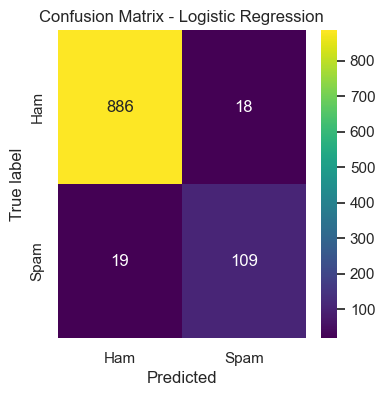

=== Random Forest ===
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       904
        Spam       1.00      0.71      0.83       128

    accuracy                           0.96      1032
   macro avg       0.98      0.86      0.91      1032
weighted avg       0.97      0.96      0.96      1032



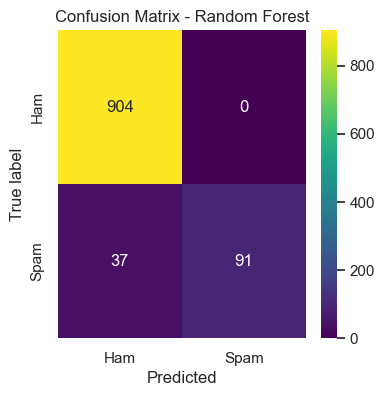

=== Linear SVM ===
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       904
        Spam       0.95      0.84      0.89       128

    accuracy                           0.97      1032
   macro avg       0.96      0.92      0.94      1032
weighted avg       0.97      0.97      0.97      1032



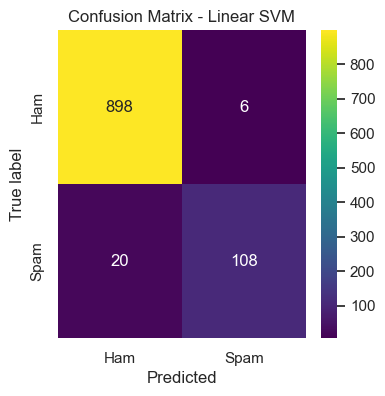

=== Multinomial NB ===
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       904
        Spam       1.00      0.59      0.75       128

    accuracy                           0.95      1032
   macro avg       0.97      0.80      0.86      1032
weighted avg       0.95      0.95      0.94      1032



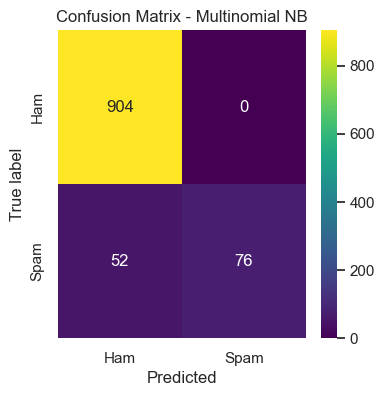

=== Passive Aggressive ===
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       904
        Spam       0.93      0.87      0.90       128

    accuracy                           0.98      1032
   macro avg       0.96      0.93      0.94      1032
weighted avg       0.98      0.98      0.98      1032



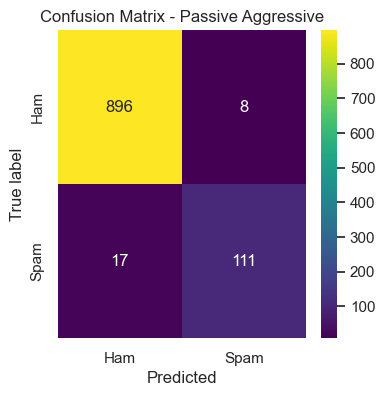

In [31]:
# Evaluate each model
summary_rows = []
for res in results:
    rpt = res["report"]
    summary_rows.append({
        "Model": res["name"],
        "Accuracy": res["accuracy"],
        "Precision (spam)": rpt["1"]["precision"],
        "Recall (spam)": rpt["1"]["recall"],
        "F1 (spam)": rpt["1"]["f1-score"]
    })

metrics_df = pd.DataFrame(summary_rows).sort_values("Accuracy", ascending=False)
print("Summary table (sorted by Accuracy):")
display(metrics_df)

print("Detailed classification reports + Confusion Matrix:")
for res in results:
    print(f"=== {res['name']} ===")
    print(classification_report(y_test, res["y_pred"], target_names=["Ham", "Spam"]))
    cm = res["cm"]
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="viridis",
        cbar=True,
        xticklabels=["Ham", "Spam"],
        yticklabels=["Ham", "Spam"],
        ax=ax
    )
    ax.set_title(f"Confusion Matrix - {res['name']}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True label")
    plt.show()


## 7. Select & save best model


### Select by F1-score (Spam) and save


Best model by F1-score (Spam): Passive Aggressive
Accuracy: 0.9758
F1-score (Spam): 0.8988


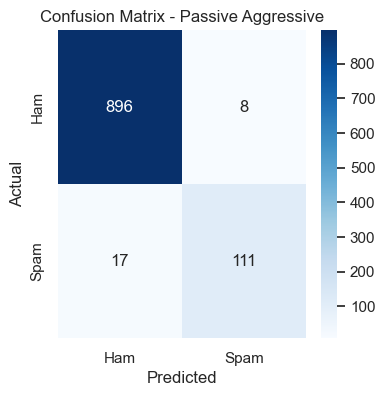

Saved best model and vectorizer.


In [32]:
# Pick best model by F1-score of Spam class
best_res = max(results, key=lambda r: r["report"]["1"]["f1-score"])
best_name = best_res["name"]
best_model = best_res["model"]
best_cm = best_res["cm"]

print(f"Best model by F1-score (Spam): {best_name}")
print(f"Accuracy: {best_res['accuracy']:.4f}")
print(f"F1-score (Spam): {best_res['report']['1']['f1-score']:.4f}")

# Confusion matrix of best model
plt.figure(figsize=(4,4))
sns.heatmap(
    best_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model and vectorizer
joblib.dump(best_model, "phanloaiemail.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Saved best model and vectorizer.")


## 8. Analyze the word “spammy”


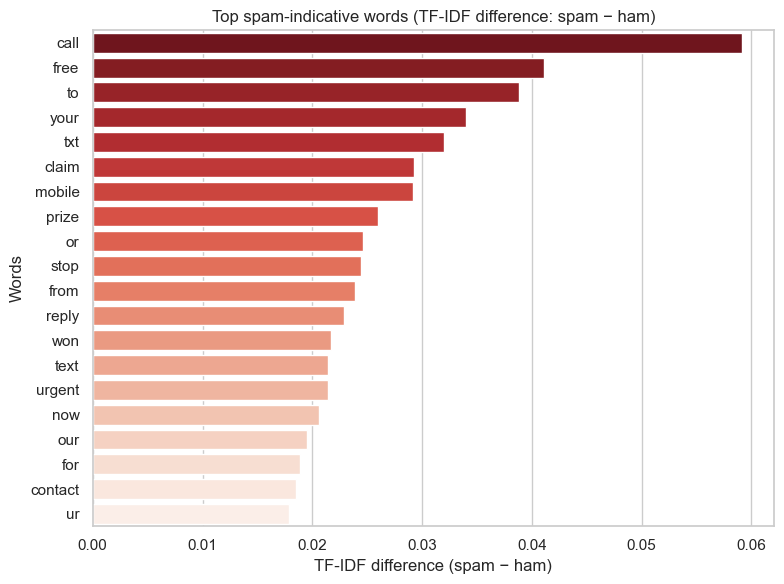

In [33]:
# Top spam-indicative words (based on the TF-IDF difference between spam and ham)
import numpy as np
feature_names = vectorizer.get_feature_names_out()

# Convert y_train to a NumPy array so the mask matches the sparse matrix
_y = np.asarray(y_train)
spam_mask = (_y == 1)
ham_mask = (_y == 0)

spam_mean = X_train_tfidf[spam_mask].mean(axis=0).A1
ham_mean  = X_train_tfidf[ham_mask].mean(axis=0).A1

df_terms = pd.DataFrame({
    'term': feature_names,
    'spam_mean': spam_mean,
    'ham_mean': ham_mean,
})
df_terms['diff'] = df_terms['spam_mean'] - df_terms['ham_mean']

top_spam = df_terms.sort_values('diff', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(data=top_spam, x='diff', y='term', hue='term', palette='Reds_r', dodge=False, legend=False)
plt.title('Top spam-indicative words (TF-IDF difference: spam − ham)')
plt.xlabel('TF-IDF difference (spam − ham)')
plt.ylabel('Words')
plt.tight_layout()
plt.show()
